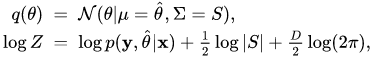

### **Least squares evidence**
Differentiate cost wrt parameters. Don't forget to divide through by $2\sigma^2$ at the end

General Gaussian error
$$ P(\{y_i\}|\theta, M) = \prod_i \frac{1}{\sqrt{2\pi}\sigma_i} \exp \left[- \frac{|y_i - f(x_i, \theta)|^2}{2\sigma_i^2}\right] $$

Our specific case
$$ \log P(\{X_i\}|\theta, \sigma) = - \frac{1}{2}N\log 2\pi - N\log\sigma - \frac{1}{2\sigma^2}\sum |\mathrm{E}[X_i] - g(\log L_i, \theta)|^2 $$ 
$$ = - \frac{1}{2}N\log (2\pi \sigma^2) - \frac{1}{2\sigma^2}\sum |\mathrm{E}[X_i] - g(\log L_i, \theta)|^2
$$
Call $ L(\theta)^2 = \sum |\mathrm{E}[X_i] - g(\log L_i, \theta)|^2 $. Maximising $\log P$ means separate maximisation of $L$ wrt $\theta$, and the result wrt $\sigma$. N is the number of data points

$$ \log P = \mathrm{const} - N\log\sigma - \frac{L^2}{2\sigma^2}$$
$$ \hat{\sigma}^2 = \frac{L^2}{N}$$


Evidence; $\Sigma = -H^{-1}$, $\log|\Sigma| = - \log|H|$ 

<!-- $$ \log Z = \log P_\mathrm{max} + \frac{1}{2} \log |\Sigma| + \frac{D}{2} \log 2\pi $$ -->
$$ \log Z = \log P_\mathrm{max} - \frac{1}{2} \log |H| + \frac{D}{2} \log 2\pi $$





In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
from scipy.optimize import minimize, least_squares

# Load test samples
from aeons.tools import pickle_in
samples_g_1, samples_c_1, samples_w_1 = pickle_in("../test_samples/samples_1.pickle")

from aeons.covariance import logX_mu, logX_Sigmainv, points_at_iteration, X_mu, X_Sigma, X_Sigmainv, data_at_iteration
from aeons.true_distribution import generate_Xs
from aeons.lm_partial import analytic_lm_params
from aeons.bayes import logPr_bayes, logPr_laplace, logPr_gaussian, minimise_ls, minimise_bayes, minimise_gaussian
from aeons.likelihoods import likelihood, linear_like, quad_like, log_like, simple_like, middle_like, full_like
linear, quad, log = linear_like(), quad_like(), log_like()
simple, middle, full = simple_like(), middle_like(), full_like()
simple_log, middle_log, full_log = simple_like(logX=True), middle_like(logX=True), full_like(logX=True)
from aeons.hessian import hess_autograd

In [428]:
def Lsquared(y, likelihood, mean_X, theta):
    loss = mean_X - likelihood.inverse(y, theta)
    return np.sum(loss**2)

def logPmax_ls(Lsquare, variance, points):
    N = points
    return -1/2 * N * np.log(2*np.pi*variance) - Lsquare/(2*variance)

def hess_ls(y, likelihood, mean_X, theta_max):
    """Hessian of Lsquared. Not yet divided through by 2*sigma**2"""
    y = torch.from_numpy(y)
    mean_X = torch.from_numpy(mean_X)
    theta_max = torch.tensor(theta_max, requires_grad=True)
    def func(theta):
        theta, sigma = theta
        loss = mean_X - likelihood.inverse(y, theta)
        return - torch.sum(loss**2)
    from torch.autograd.functional import hessian
    H = hessian(func, theta_max)
    return np.array(H)

def logZ_ls(y, likelihood, mean, theta_max, H):
    points = len(y)
    d_theta = len(theta_max)
    Lsquare = Lsquared(y, likelihood, mean, theta_max)
    variance_est = Lsquare / points
    logPmax = logPmax_ls(Lsquare, variance_est, points)
    det_H = np.linalg.det(H/(2*variance_est))
    return logPmax - 1/2 * np.log(abs(det_H)) + d_theta/2 * np.log(2*np.pi)

In [426]:
def X_end(d, sigma):
    """Returns end value of X given estimates of d, sigma"""
    from scipy.special import gamma
    return gamma(1+d/2) * 2**(d/2) * sigma**d

In [427]:
points = 2000
nk = 500 * np.ones(points)
mean_X = X_mu(nk)
# covinv_X = X_Sigmainv(nk)

Text(0.5, 1.0, 'logZ = 9235.16, [ 5.33785948 12.16489598  0.09505599]')

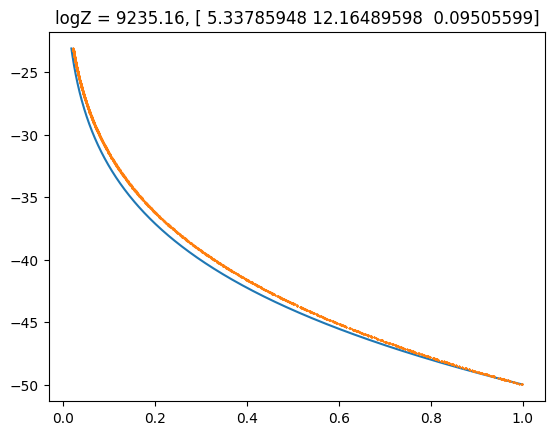

In [379]:
X = generate_Xs(nk)
theta_true = [0, 10, 0.1]
y = full.func(X, theta_true)
theta_l = minimise_ls(y, full, mean_X, theta_true).x
H = hess_ls(y, full, mean_X, theta_l)
plt.plot(full.inverse(y, theta_l), y)
plt.plot(X, y, 'x', ms=1)
logZ = logZ_ls(y, full, mean_X, theta_l, H)
plt.title(f"logZ = {logZ:.2f}, {theta_l}")

In [423]:
theta_true = [0, 10, 0.1]
logX_end_true = np.log(X_end(10, 0.1))

N = 200
logZs = np.zeros(N)
logX_ends = np.zeros(N)
for i in range(N):
    X = generate_Xs(nk)
    y = full.func(X, theta_true)
    theta_l = minimise_ls(y, full, mean_X, theta_true).x
    H = hess_ls(y, full, mean_X, theta_l)
    logZs[i] = logZ_ls(y, full, mean_X, theta_l, H)
    logX_ends[i] = np.log(X_end(theta_l[1], theta_l[2]))

In [424]:
logZ1 = logZs[::2]
logZ2 = logZs[1::2]
logX_ends1 = logX_ends[::2] - logX_end_true
logX_ends2 = logX_ends[1::2] - logX_end_true
consistent = ((logZ1 > logZ2) * (abs(logX_ends1) < abs(logX_ends2))).sum()
inconsistent = 100 - consistent
consistent, inconsistent

(33, 67)